In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display
from matplotlib.lines import Line2D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs
import cmocean

import scipy.signal as signal

import sys
sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF')
import utils


# Options

In [2]:
regions = ['SEA', 'Indo','Malay','all_countries','Viet','Cambod']
months = ['Jan','Apr','July', 'Oct'] #options are Jan, Apr, July, Oct
time = '2016'
#compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
#global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


In [3]:
region_colors = {'all_countries':'navy', 'Indo':'darkslategrey', 'Viet':'darksalmon', 'Malay':'plum', 'Cambod':'olivedrab'}

In [4]:
Indo_colors = {'Indo_Jan_Center':'teal', 'Indo_Jan_NW':'steelblue', 'Indo_Jan_SE':'lightskyblue', 'Indo_Jan':region_colors['Indo']}

In [5]:
Indo_time_colors = {'Indo_Jan_6':'teal', 'Indo_Jan_11':'lightseagreen', 'Indo_Jan_16':'mediumaquamarine', 'Indo_Jan_21':'paleturquoise', 'Indo_Jan':region_colors['Indo']}

## Import the Green's function

In [6]:
G = xr.open_dataset(f'{utils.data_output_path}greens_functions/G_combined.nc', chunks = 'auto')

In [7]:
area_ds = xr.open_dataset(f'{utils.geos_chem_data_path}stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.Emissions.20160101_0000z.nc4')

In [8]:
area_ds = utils.fix_area_ij_latlon(area_ds)


In [9]:
G_mean = G.weighted(area_ds['area']).mean(dim = ['lat','lon'])['BC_total'].isel(lev = 0).compute()

In [10]:
condition = (G.sel(run = 'all_countries_Apr') > 0).compute()
G_lev0 = G.sel(run = 'all_countries_Apr').where(condition, drop = True)

# Convolved 2x vs. step output for Indonesia

## Import Data

In [11]:
#2x pulse for GF
Jan_2x_conc = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_step/Indo_cos/2x_jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')
Jan_2x_emis = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_step/Indo_cos/2x_jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
#base
base_emis = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_base/template/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
base_conc = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')


Jan_2x_dif = Jan_2x_conc - base_conc
emis_dif = Jan_2x_emis - base_emis

#modify time 
Jan_2x_dif['time'] = Jan_2x_dif['time'].astype('datetime64')
utils.switch_conc_time(Jan_2x_dif)
#fix the area
Jan_2x_dif = utils.fix_area_ij_latlon(Jan_2x_dif)
#sum all BC conc
Jan_2x_dif['BC_total'] = Jan_2x_dif['SpeciesConc_BCPI'] + Jan_2x_dif['SpeciesConc_BCPO']

#emissions lat lon fix
emis_dif = utils.fix_area_ij_latlon(emis_dif)
#select surface since we only have surface emissions
emis_dif = emis_dif.isel(lev = -1) 
#all BC emissions
utils.combine_BC(emis_dif)


#Add height values to data
height_ds = utils.height_ds
Jan_2x_dif = xr.merge([Jan_2x_dif, height_ds['dz']], join = 'inner')


Jan_2x_dif['BC_total'] = Jan_2x_dif['BC_total']*1e9 #convert mol/mol to ppb


In [12]:
height = pd.read_excel(f'{utils.raw_data_in_path}gc_72_estimate.xlsx', index_col = 0)

## Convert to correct units

In [13]:
mw_BC = {'BC_total':12.011}

T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

#create regridder (reusing weights)
regridder = xe.Regridder(T_p_ds, Jan_2x_dif, 'bilinear', reuse_weights = True, weights = '../data_output/tp_bilinear_weights.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
T_p_ds = regridder(T_p_ds)
T_p_ds = T_p_ds.isel(time = slice(0, len(Jan_2x_dif['time'])))
T_p_ds['time'] = Jan_2x_dif['time']


In [14]:

pressure = pd.read_excel(f'{utils.raw_data_in_path}gc_72_estimate.xlsx', index_col = 0).sort_values('L')
#pressure = pressure.reindex(index=pressure.index[::-1])*-1
#pressure_ds = pressure.diff().dropna().to_xarray().rename({'L':'lev'})*100 # convert to Pa
pressure_ds = pressure.dropna().to_xarray().rename({'L':'lev'})*100 # convert to Pa

pressure_ds = pressure_ds.rename({'Pressure (hPa)':'P'}) 
pressure_ds['P'].attrs = {'units':'Pa'}

In [15]:


# pressure = pd.read_excel('../raw_data_inputs/gc_72_estimate.xlsx')
# pressure_ds = (pressure.loc[~pressure['L'].isna()].set_index(np.arange(72,0,-1))['Pressure']*100).to_xarray().rename({'index':'lev'}).sortby('lev')


utils.ppb_to_ug(Jan_2x_dif, ['BC_total'], mw_BC, pressure_ds['P'], T_p_ds['T'])

## Global means

In [16]:
emis_profile = emis_dif.weighted(area_ds['area']).sum(dim = ['lat','lon'])['EmisBC_Total']

In [17]:
G_lev0 = G.sel(run = 'Indo_Jan').isel(lev = 0)['BC_total']
G_lev0 = G_lev0.rename({'time':'s'})

## Convolution

In [18]:
temp_conv = signal.convolve(np.array(G_lev0.fillna(0)) , np.array(emis_profile.values)[..., None, None], mode = 'full')
conv_2x_ds = utils.np_to_xr(temp_conv, G_lev0, np.array(emis_profile))

## Global Mean of Convolution

In [19]:
global_mean_conv = conv_2x_ds.weighted(area_ds['area']).mean(dim = ['lat','lon'])
global_mean_2x = Jan_2x_dif.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)['BC_total']

## Mask to an individual country

In [20]:
countries = ['China','Australia', 'India']#'Myanmar', 'Laos','Philippines','Nepal','Bangladesh',
             #'Thailand','Bhutan','Brunei', 'Papua New Guinea', 'Solomon Is.', 'Timor-Leste', 'Taiwan']

In [21]:
temp_conv = {}
temp_2x = {}

indiv_country_conv = {}
indiv_country_2x = {}

for country_impacted in countries:
    ## Mask to individual countries
    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
    mask = country_mask.mask(conv_2x_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    temp_conv[country_impacted] = conv_2x_ds.where(contiguous_mask)
    temp_2x[country_impacted] = Jan_2x_dif.where(contiguous_mask)

    ##china mean##
    indiv_country_conv[country_impacted] = temp_conv[country_impacted].weighted(area_ds['area']).mean(dim = ['lat','lon'])
    indiv_country_2x[country_impacted] = temp_2x[country_impacted].weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)


/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


## Plot the individual country impact comparison

IndexError: list index out of range

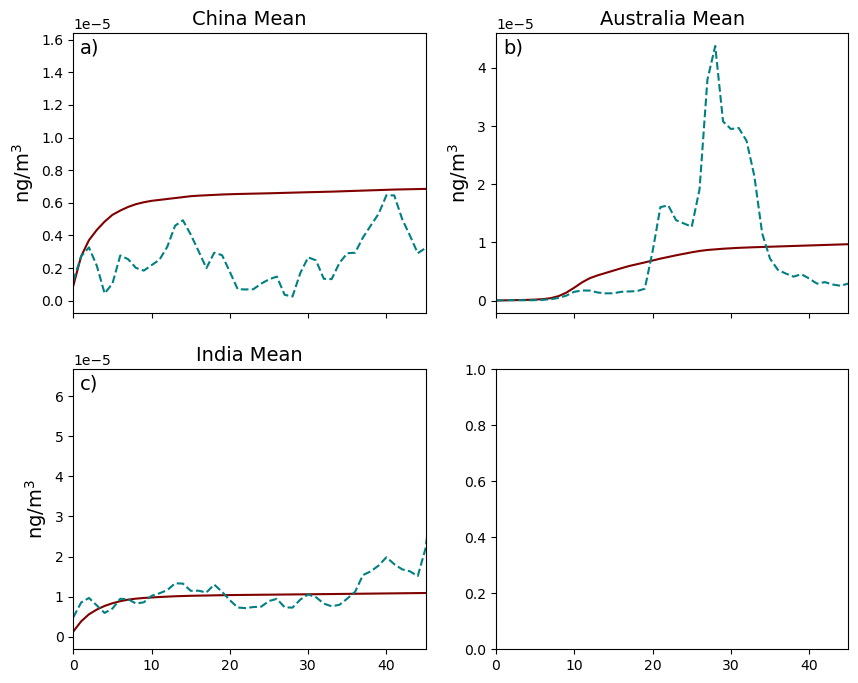

In [41]:
fig, axes = plt.subplots(2,2, figsize = (10,8), sharex = True, sharey = False)

# Define subplot labels
subplot_labels = ['a)', 'b)', 'c)', 'd)']

for ax, impacted_c, label in zip(axes.ravel(), countries + ['Global'], subplot_labels):
    if label != '(d)':  # For country plots
        country = countries[subplot_labels.index(label)]
        ax.plot(indiv_country_conv[country], label = 'Green\'s Function approach', color = 'maroon')
        ax.plot(indiv_country_2x[country]['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
        ax.set_title(f'{country} Mean', fontsize = 14)
        ax.set_ylabel('ng/m$^3$', fontsize = 14)
        ax.set_xlim(0,45)
    else:  # For global plot
        ax.plot(global_mean_conv, label = 'Green\'s Functions approach', color = 'maroon')
        ax.plot(global_mean_2x, linestyle = '--', label = 'Model Output', color = 'teal')
        ax.set_ylabel('ng/m$^3$', fontsize = 14)
        ax.set_xlabel('Days', fontsize = 14)
        ax.set_title('Global Mean', fontsize = 14)
        ax.set_xlim(0,45)
    # Add subplot label
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=14, 
            verticalalignment='top', horizontalalignment='left')

axes[1,0].set_xlabel('Days', fontsize = 14)
axes[0,1].legend()
plt.tight_layout()
plt.savefig('../figures/paper/greens_functions/GCGF_recreation.png', bbox_inches = 'tight', dpi = 350)

## RMSE To Calculate Error

In [28]:
def rmse(ds_obs, ds_expected, time):
    ds_obs = ds_obs.isel(s = slice(0, time))
    ds_expected = ds_expected.rename({'time':'s'}).isel(s = slice(0, time))
    ds_expected['s'] = np.arange(0,len(ds_expected['s']))
    rmse = np.sqrt(((ds_expected - ds_obs)**2).sum(dim = 's')/len(((ds_expected - ds_obs)**2)['s']))
    return(rmse)

In [29]:
rmse(indiv_country_conv[country_impacted], indiv_country_2x[country_impacted]['BC_total'], 60).values

array(1.46891262e-05)

In [31]:
rmse(global_mean_conv, global_mean_2x, 60).values

array(7.65466226e-06)

# Compare to cosin emissions

## Import Data

In [27]:
#Cosin inputs
Jan_cos_conc = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_step/Indo_cos/cos_jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')
Jan_cos_emis = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_step/Indo_cos/cos_jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
#base inputs
base_emis = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_base/template/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
base_conc = xr.open_mfdataset(f'{utils.geos_chem_data_path}stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')


In [28]:
#take difference from the base
Jan_cos_dif = Jan_cos_conc - base_conc
emis_cos_dif = Jan_cos_emis - base_emis

#fix the time units
Jan_cos_dif['time'] = Jan_cos_dif['time'].astype('datetime64')
utils.switch_conc_time(Jan_cos_dif)
#fix the area
Jan_cos_dif = utils.fix_area_ij_latlon(Jan_cos_dif)
#sum all BC conc
Jan_cos_dif['BC_total'] = Jan_cos_dif['SpeciesConc_BCPI'] + Jan_cos_dif['SpeciesConc_BCPO']

#fix the area
emis_cos_dif = utils.fix_area_ij_latlon(emis_cos_dif)
 #select surface since we only have surface emissions
emis_cos_dif = emis_cos_dif.isel(lev = -1)
#combine emissions
utils.combine_BC(emis_cos_dif)



### Add height to data
height_ds = utils.height_ds
Jan_cos_dif = xr.merge([Jan_cos_dif, height_ds['dz']], join = 'inner')



## Convert to correct Units

In [29]:
mw_BC = {'BC_total':12.011}

T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})


In [30]:

#create regridder (reusing weights)
regridder = xe.Regridder(T_p_ds, Jan_cos_dif, 'bilinear', reuse_weights = True, weights = '../data_output/tp_bilinear_weights.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
T_p_ds = regridder(T_p_ds)
T_p_ds = T_p_ds.isel(time = slice(0, len(Jan_cos_dif['time'])))
T_p_ds['time'] = Jan_cos_dif['time']

# pressure_ds = utils.pressure_ds

Jan_cos_dif['BC_total'] = Jan_cos_dif['BC_total']*1e9 #convert mol/mol to ppb
utils.ppb_to_ug(Jan_cos_dif, ['BC_total'], mw_BC, pressure_ds['P'], T_p_ds['T'])

## Take Global Means

In [31]:
emis_cos_profile = emis_cos_dif.weighted(area_ds['area']).sum(dim = ['lat','lon'])['EmisBC_Total']

In [32]:
G_lev0 = G.sel(run = 'Indo_Jan').isel(lev = 0)['BC_total']
condition = (G_lev0 > 0).compute()
G_lev0 = G_lev0.where(condition, drop = True)
G_lev0 = G_lev0.rename({'time':'s'})

## Convolve

In [33]:
temp_conv = signal.convolve(np.array(G_lev0.fillna(0)) , np.array(emis_cos_profile.values)[..., None, None], mode = 'full')
conv_viet_cos_ds = utils.np_to_xr(temp_conv, G_lev0, np.array(emis_cos_profile))

## Global Mean Convolution

In [34]:
##global mean##
global_mean_conv_cos = conv_viet_cos_ds.weighted(area_ds['area']).mean(dim = ['lat','lon'])
full_cos = Jan_cos_dif.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)

## Compare to a sustained increase/percent change

In [35]:
## compare to the percent change
Jan_2x_dif['time']= emis_profile['time']
src_receptor_apprch = (Jan_2x_dif['BC_total'].isel(lev = 0)/emis_profile)

#take the area weighted mean
mean_src_receptor_apprch = src_receptor_apprch.weighted(area_ds['area']).mean(dim = ['lat','lon'])

## Mask to an Individual Country

In [36]:
indiv_country_conv_cos_ds = {}
indiv_country_cos_ds = {}
indiv_src_receptor_ds = {}

indiv_country_conv_cos = {}
indiv_country_cos = {}
indiv_src_receptor = {}
contiguous_mask = {}

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
mask = country_mask.mask(conv_viet_cos_ds, lon_name = 'lon', lat_name = 'lat')

for country_impacted in countries:
    ## Mask to individual countries

    contiguous_mask[country_impacted] = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    indiv_country_conv_cos_ds[country_impacted] = conv_viet_cos_ds.where(contiguous_mask[country_impacted])
    indiv_country_cos_ds[country_impacted] = Jan_cos_dif.where(contiguous_mask[country_impacted])
    indiv_src_receptor_ds[country_impacted] = src_receptor_apprch.where(contiguous_mask[country_impacted])
    
    a_loc_ds = area_ds['area'].where(contiguous_mask[country_impacted]).fillna(0)
    
    ##china mean##
    indiv_country_conv_cos[country_impacted] = indiv_country_conv_cos_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon'])
    indiv_country_cos[country_impacted] = indiv_country_cos_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon']).isel(lev = 0)
    indiv_src_receptor[country_impacted] = indiv_src_receptor_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon'])
    print(country_impacted)


/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


China


Australia
India


## Plot the country level Cosin

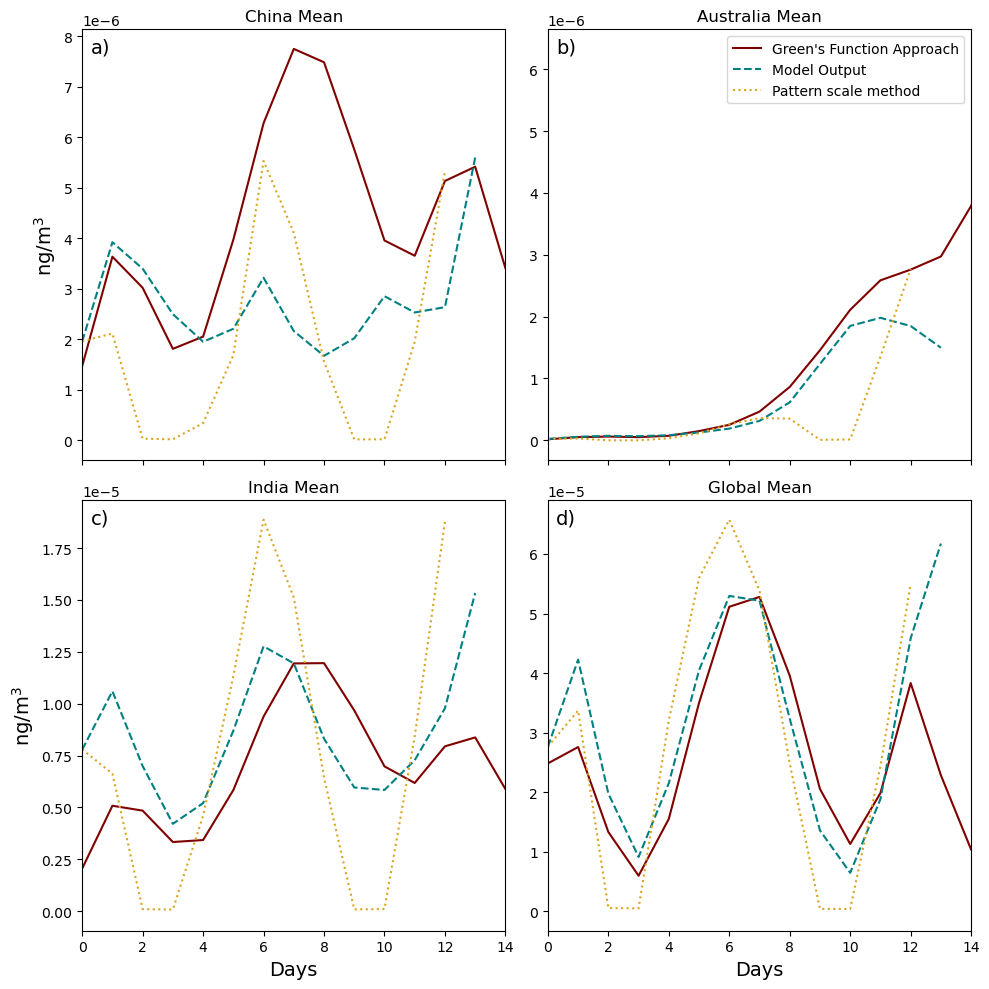

In [42]:
fig, axes = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = False)

# Define subplot labels


subplot_labels = ['a)', 'b)', 'c)', 'd)']

for ax, country_impacted, label in zip(axes.ravel(), countries + ['Global'], subplot_labels):
    if label != 'd)':  # For country plots
        ax.plot(indiv_country_conv_cos[country_impacted], label = 'Green\'s Function Approach', color = 'maroon')
        ax.plot(indiv_country_cos[country_impacted]['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
        ax.plot(indiv_src_receptor[country_impacted]*emis_cos_profile, linestyle = ':', label = 'Pattern scale method', color = 'goldenrod')
        ax.set_title(f'{country_impacted} Mean')
        ax.set_ylabel(None)
        ax.set_xlabel(None)    
        ax.set_xlim(0,14)
    else:
        ax.plot(global_mean_conv_cos, label = 'Green\'s Function Approach', color = 'maroon')
        ax.plot(full_cos['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
        ax.plot(mean_src_receptor_apprch*emis_cos_profile, linestyle = ':', label = 'Pattern scale method', color = 'goldenrod')
        
        ax.set_ylabel(None)
        ax.set_xlabel('Days', fontsize = 14)
        ax.set_title('Global Mean')
        ax.set_xlim(0,14)
    # Add subplot label
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left')
    
axes[0,0].set_ylabel('ng/m$^3$', fontsize = 14)
axes[1,0].set_ylabel('ng/m$^3$', fontsize = 14)
axes[1,0].set_xlabel('Days', fontsize = 14)
axes[0,1].legend()

plt.tight_layout()
plt.savefig('../figures/paper/greens_functions/cosin_recreation.png', bbox_inches = 'tight', dpi = 350)

In [32]:
## Calc the error

In [44]:
def calc_correlation(actual, predic):
    actual['time'] = np.arange(0,len(actual['time']))
    actual = actual.rename({'time':'s'})  
    a_diff = actual - actual.mean()
    p_diff = predic - predic.mean() 
    num = np.sum(a_diff*p_diff)
    denom = np.sqrt(np.sum(a_diff**2))*np.sqrt(np.sum(p_diff**2))
    pearson = (num/denom).values
    return (pearson)

/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(


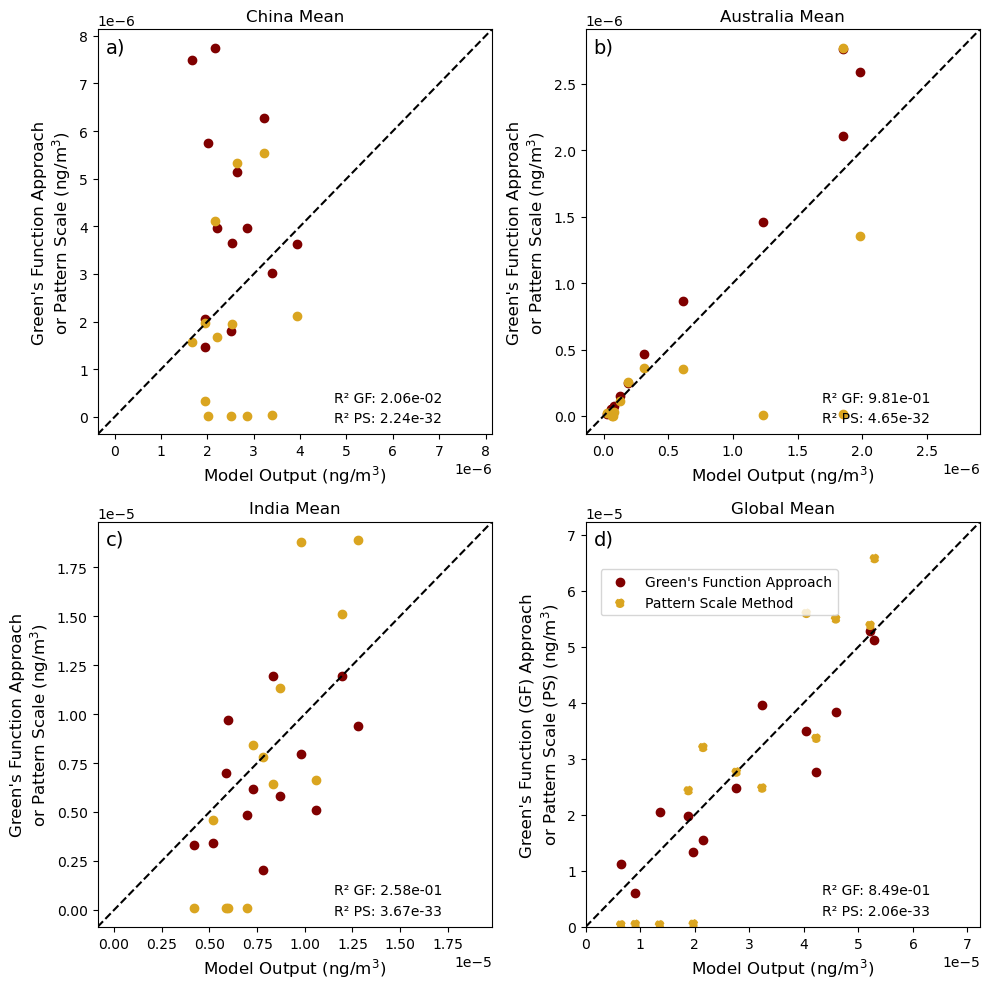

In [50]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

# Define subplot labels
subplot_labels = ['a)', 'b)', 'c)', 'd)']

for i, (ax, country_impacted) in enumerate(zip(axes.ravel()[:3], countries)):
    # Get data for this country
    model_output = indiv_country_cos[country_impacted]['BC_total'][:13]
    greens_func = indiv_country_conv_cos[country_impacted][:13]
    pattern_scale = indiv_src_receptor[country_impacted]*emis_cos_profile[:13]
    
    # Plot scatter points
    ax.scatter(model_output, greens_func, label = 'Green\'s Function Approach', color = 'maroon', marker = 'o')
    ax.scatter(model_output, pattern_scale, label = 'Pattern scale method', color = 'goldenrod')
    
    # Get min and max values for setting limits
    all_values = np.concatenate([model_output.values, greens_func.values, pattern_scale.values])
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    
    # Add some padding (5% of range)
    padding = (max_val - min_val) * 0.05
    lim_min = min_val - padding
    lim_max = max_val + padding
    
    # Set equal limits for both axes
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    
    # Draw perfect diagonal line across the full range
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color = 'k', linestyle = '--')
    
    ax.set_title(f'{country_impacted} Mean')
    ax.set_ylabel('Green\'s Function Approach\nor Pattern Scale (ng/m$^3$)', fontsize = 12)
    ax.set_xlabel('Model Output (ng/m$^3$)', fontsize = 12)
    
    # Add R² values as text
    r2_greens = calc_correlation(model_output, greens_func)**2
    r2_pattern = calc_correlation(model_output, pattern_scale)**2
    ax.text(0.6, 0.08, f'R² GF: {r2_greens:.2e}', transform=ax.transAxes, fontsize=10)
    ax.text(0.6, 0.03, f'R² PS: {r2_pattern:.2e}', transform=ax.transAxes, fontsize=10)
    
    # Add subplot label
    ax.text(0.02, 0.98, subplot_labels[i], transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left')

ax_global = axes[1,1]

global_model = full_cos['BC_total'][:13]
global_gf = global_mean_conv_cos[:13]
global_ps = (mean_src_receptor_apprch*emis_cos_profile)[:13]
ax_global.scatter(global_model, global_gf, label = 'Green\'s Function Approach', color = 'maroon')
ax_global.scatter(global_model, global_ps, linestyle = '--', label = 'Pattern Scale Method', color = 'goldenrod')
ax_global.legend(bbox_to_anchor=(0.02, 0.9), loc='upper left')
ax_global.set_ylabel(None)
ax_global.set_title('Global Mean')

# Get min and max values for setting limits
all_values = np.concatenate([global_model.values, global_gf.values, global_ps.values])
min_val = np.min(all_values)
max_val = np.max(all_values)

# Add some padding (5% of range)
padding = (max_val - min_val) * 0.1
lim_min = min_val - padding
lim_max = max_val + padding

# Set equal limits for both axes
ax_global.set_xlim(0, lim_max)
ax_global.set_ylim(0, lim_max)

ax_global.set_ylabel('Green\'s Function (GF) Approach\nor Pattern Scale (PS) (ng/m$^3$)', fontsize = 12)
ax_global.set_xlabel('Model Output (ng/m$^3$)', fontsize = 12)

# Add R² values as text
r2_greens = calc_correlation(global_model, global_gf)**2
r2_pattern = calc_correlation(global_model, global_ps)**2
ax_global.text(0.6, 0.08, f'R² GF: {r2_greens:.2e}', transform=ax_global.transAxes, fontsize=10)
ax_global.text(0.6, 0.03, f'R² PS: {r2_pattern:.2e}', transform=ax_global.transAxes, fontsize=10)

# Add subplot label for global plot
ax_global.text(0.02, 0.98, 'd)', transform=ax_global.transAxes, fontsize=14, 
               verticalalignment='top', horizontalalignment='left')

# Draw perfect diagonal line across the full range
ax_global.plot([0, lim_max], [0, lim_max], color = 'k', linestyle = '--')

plt.tight_layout()
plt.savefig('../figures/paper/greens_functions/scatter_comparison.png', bbox_inches = 'tight', dpi = 350)

In [63]:
calc_correlation(indiv_country_cos['China']['BC_total'], indiv_country_conv_cos['China'])

array(0.01351314)

In [66]:
calc_correlation(indiv_country_cos['China']['BC_total'], indiv_src_receptor['China'])

/home/emfreese/miniconda3/envs/bc-irf/lib/python3.9/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(


array(4.52054503e-17)

array(0.01351314)